In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torchsummary import summary 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class NoisyMNIST(Dataset):
    def __init__(self, root="./data", train=True, noise_std=0.5):
        """
        root : str
            Dossier de téléchargement
        train : bool
            True = ensemble d'apprentissage, False = test
        noise_std : float
            Écart-type du bruit gaussien
        """
        self.mnist = datasets.MNIST(
            root=root, train=train, download=True,
            transform=transforms.ToTensor()
        )
        self.noise_std = noise_std

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        clean_img, _ = self.mnist[idx]   
        noise = torch.randn_like(clean_img) * self.noise_std
        noisy_img = torch.clamp(clean_img + noise, 0., 1.)  
        return noisy_img, clean_img


batch_size = 128
train_dataset = NoisyMNIST(train=True, noise_std=0.5)
test_dataset = NoisyMNIST(train=False, noise_std=0.5)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
class DnCNN_Block(nn.Module):
    """A Block of a DnCNN.
    """
    def __init__(self, num_of_features=4):
        """
        Parameters
        ----------
        num_of_features : int, optional
        Number of convolution filters. The default is 16.
        """
        super(DnCNN_Block, self).__init__()
        
        self.conv = nn.Conv2d(
            in_channels=num_of_features,
            out_channels=num_of_features,
            kernel_size=3,
            padding=1,
            bias=False
        )

        self.bn = nn.BatchNorm2d(num_of_features)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.conv(x)
        y = self.bn(y)
        y = self.relu(y)
        return y


In [4]:
class DnCNN(nn.Module):
    """A DnCNN.
    """
    def __init__(self, num_of_features=64, num_of_layers=10, skip_connection=True):
        """
        Parameters
        ----------
        num_of_features : int, optional
        Number of filters in each block. The default is 64.
        num_of_layers : int, optional
        Number of layers. The default is 10.
        skip_connection : boolean, optional
        True if skip_connection. The default is True.
        """
        super(DnCNN, self).__init__()
        
        self.skip_connection = skip_connection
        
        layers = []
        
        layers.append(nn.Conv2d(1, num_of_features, kernel_size=3, padding=1, bias=False))
        layers.append(nn.ReLU(inplace=True))
        
        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv2d(num_of_features, num_of_features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(num_of_features))
            layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.Conv2d(num_of_features, 1, kernel_size=3, padding=1, bias=False))
        
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        
        if self.skip_connection:
            y = x - out
        else:
            y = out
        
        return y

In [5]:
model = DnCNN(num_of_features=64, num_of_layers=2, skip_connection=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             576
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3            [-1, 1, 28, 28]             576
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.77
Params size (MB): 0.00
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


In [6]:
# ---- Fonction utilitaire pour compter les paramètres ----
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ---- Configurations à tester ----
configs = [
    {"num_of_layers": 1, "num_of_features": 1},
    {"num_of_layers": 1, "num_of_features": 2},
    {"num_of_layers": 1, "num_of_features": 4},
    {"num_of_layers": 1, "num_of_features": 8},
    {"num_of_layers": 1, "num_of_features": 16},
    {"num_of_layers": 1, "num_of_features": 32},
    {"num_of_layers": 1, "num_of_features": 64},
    {"num_of_layers": 2, "num_of_features": 1},
    {"num_of_layers": 2, "num_of_features": 2},
    {"num_of_layers": 2, "num_of_features": 4},
    {"num_of_layers": 2, "num_of_features": 8},
    {"num_of_layers": 2, "num_of_features": 16},
    {"num_of_layers": 2, "num_of_features": 32},
    {"num_of_layers": 2, "num_of_features": 64},
    {"num_of_layers": 4, "num_of_features": 1},
    {"num_of_layers": 4, "num_of_features": 2},
    {"num_of_layers": 4, "num_of_features": 4},
    {"num_of_layers": 4, "num_of_features": 8},
    {"num_of_layers": 4, "num_of_features": 16},
    {"num_of_layers": 4, "num_of_features": 32},
    {"num_of_layers": 4, "num_of_features": 64},
    {"num_of_layers": 8, "num_of_features": 1},
    {"num_of_layers": 8, "num_of_features": 2},
    {"num_of_layers": 8, "num_of_features": 4},
    {"num_of_layers": 8, "num_of_features": 8},
    {"num_of_layers": 8, "num_of_features": 16},
    {"num_of_layers": 8, "num_of_features": 32},
    {"num_of_layers": 8, "num_of_features": 64},
]

# ---- Calcul du nombre de paramètres ----
for cfg in configs:
    model = DnCNN(num_of_features=cfg["num_of_features"], num_of_layers=cfg["num_of_layers"], skip_connection=True)
    n_params = count_params(model)
    print(f"num_of_layers={cfg['num_of_layers']}, num_of_features={cfg['num_of_features']} → {n_params:,} paramètres")

num_of_layers=1, num_of_features=1 → 18 paramètres
num_of_layers=1, num_of_features=2 → 36 paramètres
num_of_layers=1, num_of_features=4 → 72 paramètres
num_of_layers=1, num_of_features=8 → 144 paramètres
num_of_layers=1, num_of_features=16 → 288 paramètres
num_of_layers=1, num_of_features=32 → 576 paramètres
num_of_layers=1, num_of_features=64 → 1,152 paramètres
num_of_layers=2, num_of_features=1 → 18 paramètres
num_of_layers=2, num_of_features=2 → 36 paramètres
num_of_layers=2, num_of_features=4 → 72 paramètres
num_of_layers=2, num_of_features=8 → 144 paramètres
num_of_layers=2, num_of_features=16 → 288 paramètres
num_of_layers=2, num_of_features=32 → 576 paramètres
num_of_layers=2, num_of_features=64 → 1,152 paramètres
num_of_layers=4, num_of_features=1 → 40 paramètres
num_of_layers=4, num_of_features=2 → 116 paramètres
num_of_layers=4, num_of_features=4 → 376 paramètres
num_of_layers=4, num_of_features=8 → 1,328 paramètres
num_of_layers=4, num_of_features=16 → 4,960 paramètres
num_

In [10]:
# Instancier le modèle
model = DnCNN(num_of_features=32, num_of_layers=8, skip_connection=True).to(device)

# Définir la fonction de perte (MSE)
criterion = nn.MSELoss()

# Définir l’optimiseur Adam
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Boucle d’apprentissage 
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for noisy_imgs, clean_imgs in train_loader: 
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        
        outputs = model(noisy_imgs)
        
        loss = criterion(outputs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")


Epoch [1/5], Loss: 0.016841
Epoch [2/5], Loss: 0.011465
Epoch [3/5], Loss: 0.010864
Epoch [4/5], Loss: 0.010467
Epoch [5/5], Loss: 0.010292


In [14]:
# Fonction pour calculer le PSNR 
def psnr(clean, denoised): 
    mse = F.mse_loss(denoised, clean, reduction='sum') / clean.numel() 
    n = clean[0].numel() 
    return 10 * torch.log10(4 * n / (mse * clean.size(0)))

MSE (test): 0.010416
PSNR (test): 33.83 dB


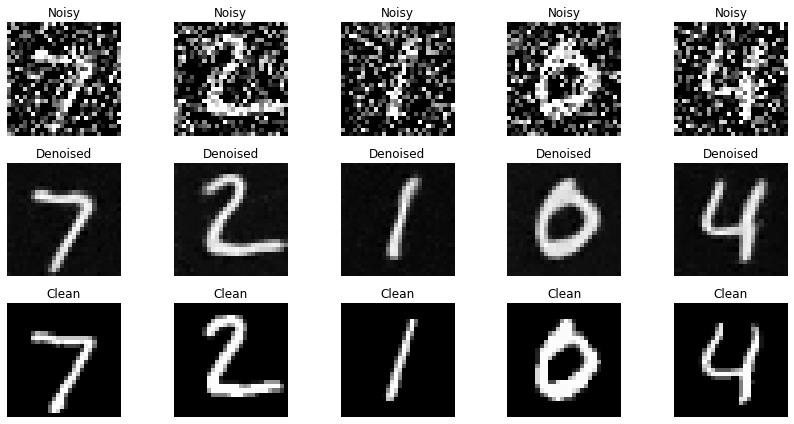

In [15]:
# Évaluation sur le test set
model.eval()
test_mse, test_psnr = 0.0, 0.0

with torch.no_grad():
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        
        denoised = model(noisy)
        
        mse_batch = F.mse_loss(denoised, clean, reduction="mean").item()
        test_mse += mse_batch
        
        psnr_batch = psnr(clean, denoised).item()
        test_psnr += psnr_batch

# Moyenne sur tous les batches
test_mse /= len(test_loader)
test_psnr /= len(test_loader)

print(f"MSE (test): {test_mse:.6f}")
print(f"PSNR (test): {test_psnr:.2f} dB")

# Visualisation de quelques résultats
noisy, clean = next(iter(test_loader))
noisy, clean = noisy.to(device), clean.to(device)
with torch.no_grad():
    denoised = model(noisy)

num_show = 5
fig, axes = plt.subplots(3, num_show, figsize=(12, 6))
for i in range(num_show):
    axes[0, i].imshow(noisy[i].cpu().squeeze(), cmap="gray")
    axes[0, i].set_title("Noisy")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(denoised[i].cpu().squeeze(), cmap="gray")
    axes[1, i].set_title("Denoised")
    axes[1, i].axis("off")
    
    axes[2, i].imshow(clean[i].cpu().squeeze(), cmap="gray")
    axes[2, i].set_title("Clean")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

In [22]:
# Configurations à tester
configs = [
    {"features": 4, "num_layers": 2, "skip": True},
    {"features": 4, "num_layers": 4, "skip": True},
    {"features": 4, "num_layers": 8, "skip": True},
    {"features": 8, "num_layers": 1, "skip": True},
    {"features": 8, "num_layers": 2, "skip": True},
]

results = []

for cfg in configs:
    print(f"\nTesting DnCNN with {cfg['num_layers']} layers, features={cfg['features']}, skip={cfg['skip']}")
    
    model = DnCNN(
        num_of_features=cfg["features"],
        num_of_layers=cfg["num_layers"],
        skip_connection=cfg["skip"]
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Entraînement rapide (par exemple 3-5 époques)
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for noisy, clean in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")
    
    # Évaluation sur le test set
    model.eval()
    test_mse, test_psnr = 0.0, 0.0
    with torch.no_grad():
        for noisy, clean in test_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            denoised = model(noisy)
            test_mse += criterion(denoised, clean).item()
            test_psnr += psnr(clean, denoised).item()
    
    test_mse /= len(test_loader)
    test_psnr /= len(test_loader)
    results.append((cfg, test_mse, test_psnr))
    
    print(f"Test MSE: {test_mse:.6f}, PSNR: {test_psnr:.2f} dB")

# Résumé final
print("\nSummary of results:")
for cfg, mse, psnr_val in results:
    print(f"Layers={cfg['num_layers']}, Features={cfg['features']} -> MSE={mse:.6f}, PSNR={psnr_val:.2f} dB")



Testing DnCNN with 2 layers, features=4, skip=True
Epoch [1/5], Loss: 0.052731
Epoch [2/5], Loss: 0.027526
Epoch [3/5], Loss: 0.025403
Epoch [4/5], Loss: 0.024746
Epoch [5/5], Loss: 0.024459
Test MSE: 0.024179, PSNR: 30.17 dB

Testing DnCNN with 4 layers, features=4, skip=True
Epoch [1/5], Loss: 0.042450
Epoch [2/5], Loss: 0.021224
Epoch [3/5], Loss: 0.018483
Epoch [4/5], Loss: 0.017251
Epoch [5/5], Loss: 0.016323
Test MSE: 0.015697, PSNR: 32.05 dB

Testing DnCNN with 8 layers, features=4, skip=True
Epoch [1/5], Loss: 0.072085
Epoch [2/5], Loss: 0.026522
Epoch [3/5], Loss: 0.019014
Epoch [4/5], Loss: 0.016746
Epoch [5/5], Loss: 0.015978
Test MSE: 0.015413, PSNR: 32.13 dB

Testing DnCNN with 1 layers, features=8, skip=True
Epoch [1/5], Loss: 0.040337
Epoch [2/5], Loss: 0.025768
Epoch [3/5], Loss: 0.024808
Epoch [4/5], Loss: 0.024374
Epoch [5/5], Loss: 0.023940
Test MSE: 0.023488, PSNR: 30.30 dB

Testing DnCNN with 2 layers, features=8, skip=True
Epoch [1/5], Loss: 0.044928
Epoch [2/5],

In [4]:
# Bloc contractant (encodeur)
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)  

    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down  

# Bloc expansif (decodeur)
class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpansiveBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        # Ajuster la taille pour correspondre au skip
        if x.size()[2:] != skip.size()[2:]:
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                          diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

# Architecture complète U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_layers=4, features_start=64):
        """
        Paramètres
        ----------
        in_channels : int
            Nombre de canaux d'entrée (1 pour MNIST)
        out_channels : int
            Nombre de canaux de sortie (1 pour MNIST)
        num_layers : int
            Nombre de niveaux d'encodeur/décodeur
        features_start : int
            Nombre de filtres au 1er niveau
        """
        super(UNet, self).__init__()
        
        self.contracting_blocks = nn.ModuleList()
        self.expansive_blocks = nn.ModuleList()

        # Partie contractante
        features = features_start
        for i in range(num_layers):
            self.contracting_blocks.append(ContractingBlock(in_channels, features))
            in_channels = features
            features *= 2

        # Bottleneck 
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

        # Partie expansive
        for i in range(num_layers):
            self.expansive_blocks.append(ExpansiveBlock(features, features // 2))
            features //= 2

        # Couche finale
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        # Encodeur
        for block in self.contracting_blocks:
            x_conv, x = block(x)
            skips.append(x_conv)

        # Bottleneck
        x = self.bottleneck(x)

        # Decodeur 
        for block in self.expansive_blocks:
            skip = skips.pop()  
            x = block(x, skip)

        return self.final_conv(x)

In [6]:
# Exemple de U-Net
unet_model = UNet(
    in_channels=3, 
    out_channels=3, 
    num_layers=3,       
    features_start=32  
).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model.to(device)

summary(unet_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
  ContractingBlock-8  [[-1, 32, 32, 32], [-1, 32, 16, 16]]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14        

In [35]:
# ---- Fonction utilitaire pour compter les paramètres ----
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ---- Configurations à tester ----
configs = [
    {"num_layers": 1, "features_start": 1},
    {"num_layers": 1, "features_start": 2},
    {"num_layers": 1, "features_start": 4},
    {"num_layers": 1, "features_start": 8},
    {"num_layers": 1, "features_start": 16},
    {"num_layers": 1, "features_start": 32},
    {"num_layers": 1, "features_start": 64},
    {"num_layers": 2, "features_start": 1},
    {"num_layers": 2, "features_start": 2},
    {"num_layers": 2, "features_start": 4},
    {"num_layers": 2, "features_start": 8},
    {"num_layers": 2, "features_start": 16},
    {"num_layers": 2, "features_start": 32},
    {"num_layers": 2, "features_start": 64},
    {"num_layers": 3, "features_start": 1},
    {"num_layers": 3, "features_start": 2},
    {"num_layers": 3, "features_start": 4},
    {"num_layers": 3, "features_start": 8},
    {"num_layers": 3, "features_start": 16},
    {"num_layers": 3, "features_start": 32},
    {"num_layers": 3, "features_start": 64},
]

# ---- Calcul du nombre de paramètres ----
for cfg in configs:
    model = UNet(in_channels=1, out_channels=1, num_layers=cfg["num_layers"], features_start=cfg["features_start"])
    n_params = count_params(model)
    print(f"L={cfg['num_layers']}, F0={cfg['features_start']} → {n_params:,} paramètres")

L=1, F0=1 → 134 paramètres
L=1, F0=2 → 463 paramètres
L=1, F0=4 → 1,709 paramètres
L=1, F0=8 → 6,553 paramètres
L=1, F0=16 → 25,649 paramètres
L=1, F0=32 → 101,473 paramètres
L=1, F0=64 → 403,649 paramètres
L=2, F0=1 → 528 paramètres
L=2, F0=2 → 1,963 paramètres
L=2, F0=4 → 7,557 paramètres
L=2, F0=8 → 29,641 paramètres
L=2, F0=16 → 117,393 paramètres
L=2, F0=32 → 467,233 paramètres
L=2, F0=64 → 1,864,257 paramètres
L=3, F0=1 → 2,028 paramètres
L=3, F0=2 → 7,811 paramètres
L=3, F0=4 → 30,645 paramètres
L=3, F0=8 → 121,385 paramètres
L=3, F0=16 → 483,153 paramètres
L=3, F0=32 → 1,927,841 paramètres
L=3, F0=64 → 7,701,825 paramètres


In [48]:
# Fonction de perte et optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model.parameters(), lr=1e-3)

# Boucle d’apprentissage
num_epochs = 5
for epoch in range(num_epochs):
    unet_model.train()
    running_loss = 0.0
    
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        
        outputs = unet_model(noisy_imgs)
        
        loss = criterion(outputs, clean_imgs)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

Epoch [1/5], Loss: 0.096672
Epoch [2/5], Loss: 0.018463
Epoch [3/5], Loss: 0.014831
Epoch [4/5], Loss: 0.014166
Epoch [5/5], Loss: 0.013739


U-Net Test MSE: 0.013321
U-Net Test PSNR: 32.77 dB


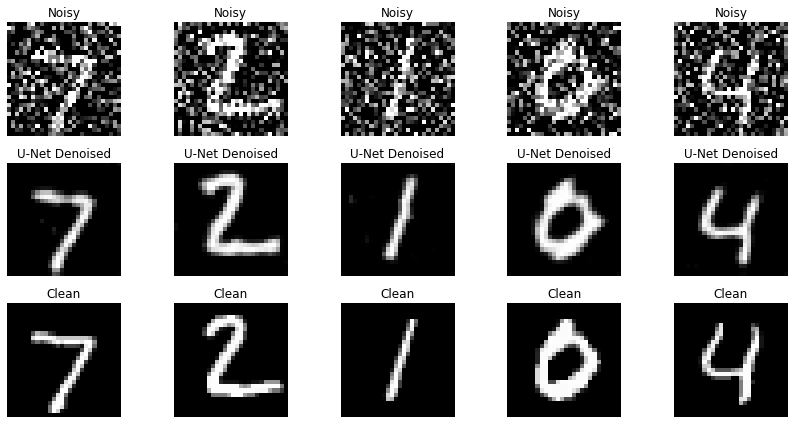

In [49]:
# Évaluation
unet_model.eval()
test_mse, test_psnr = 0, 0
with torch.no_grad():
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        denoised = unet_model(noisy)
        test_mse += F.mse_loss(denoised, clean, reduction='mean').item()
        test_psnr += psnr(clean, denoised).item()

test_mse /= len(test_loader)
test_psnr /= len(test_loader)

print(f"U-Net Test MSE: {test_mse:.6f}")
print(f"U-Net Test PSNR: {test_psnr:.2f} dB")

# Visualisation de quelques résultats
noisy, clean = next(iter(test_loader))
noisy, clean = noisy.to(device), clean.to(device)

with torch.no_grad():
    denoised = unet_model(noisy)

num_show = 5
fig, axes = plt.subplots(3, num_show, figsize=(12,6))
for i in range(num_show):
    axes[0,i].imshow(noisy[i].cpu().squeeze(), cmap='gray')
    axes[0,i].set_title('Noisy')
    axes[0,i].axis('off')

    axes[1,i].imshow(denoised[i].cpu().squeeze(), cmap='gray')
    axes[1,i].set_title('U-Net Denoised')
    axes[1,i].axis('off')

    axes[2,i].imshow(clean[i].cpu().squeeze(), cmap='gray')
    axes[2,i].set_title('Clean')
    axes[2,i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Configurations à tester
configs = [
    {"num_layers": 1, "features_start": 1},
    {"num_layers": 1, "features_start": 2},
    {"num_layers": 1, "features_start": 4},
    {"num_layers": 1, "features_start": 8},
    {"num_layers": 1, "features_start": 16},
    {"num_layers": 1, "features_start": 32},
    {"num_layers": 1, "features_start": 64},
    {"num_layers": 2, "features_start": 1},
    {"num_layers": 2, "features_start": 2},
    {"num_layers": 2, "features_start": 4},
    {"num_layers": 2, "features_start": 8},
    {"num_layers": 2, "features_start": 16},
    {"num_layers": 2, "features_start": 32},
    {"num_layers": 2, "features_start": 64},
    {"num_layers": 3, "features_start": 1},
    {"num_layers": 3, "features_start": 2},
    {"num_layers": 3, "features_start": 4},
    {"num_layers": 3, "features_start": 8},
    {"num_layers": 3, "features_start": 16},
    {"num_layers": 3, "features_start": 32},
    {"num_layers": 3, "features_start": 64},
]

results = []

for cfg in configs:
    print(f"\nTesting U-Net with L={cfg['num_layers']}, F0={cfg['features_start']}")
    
    model = UNet(
        in_channels=1,
        out_channels=1,
        num_layers=cfg["num_layers"],
        features_start=cfg["features_start"]
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Entraînement
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for noisy, clean in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")
    
    # Évaluation 
    model.eval()
    test_mse, test_psnr = 0.0, 0.0
    with torch.no_grad():
        for noisy, clean in test_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            denoised = model(noisy)
            test_mse += F.mse_loss(denoised, clean, reduction='mean').item()
            test_psnr += psnr(clean, denoised).item()
    
    test_mse /= len(test_loader)
    test_psnr /= len(test_loader)
    results.append((cfg, test_mse, test_psnr))
    
    print(f"Test MSE: {test_mse:.6f}, PSNR: {test_psnr:.2f} dB")

# Résumé final
print("\nSummary of results:")
for cfg, mse, psnr_val in results:
    print(f"L={cfg['num_layers']}, F0={cfg['features_start']} -> MSE={mse:.6f}, PSNR={psnr_val:.2f} dB")



Testing U-Net with L=1, F0=1
Epoch [1/5], Loss: 0.097596
Epoch [2/5], Loss: 0.064355
Epoch [3/5], Loss: 0.028782
Epoch [4/5], Loss: 0.019731
Epoch [5/5], Loss: 0.016711
Test MSE: 0.021416, PSNR: 30.70 dB

Testing U-Net with L=1, F0=2
Epoch [1/5], Loss: 0.043270
Epoch [2/5], Loss: 0.018403
Epoch [3/5], Loss: 0.015256
Epoch [4/5], Loss: 0.014249
Epoch [5/5], Loss: 0.013878
Test MSE: 0.013530, PSNR: 32.70 dB

Testing U-Net with L=1, F0=4
Epoch [1/5], Loss: 0.024396
Epoch [2/5], Loss: 0.014063
Epoch [3/5], Loss: 0.012722
Epoch [4/5], Loss: 0.012243
Epoch [5/5], Loss: 0.011919
Test MSE: 0.011671, PSNR: 33.34 dB

Testing U-Net with L=1, F0=8
Epoch [1/5], Loss: 0.019352
Epoch [2/5], Loss: 0.012277
Epoch [3/5], Loss: 0.011625
Epoch [4/5], Loss: 0.011264
Epoch [5/5], Loss: 0.011066
Test MSE: 0.010842, PSNR: 33.66 dB

Testing U-Net with L=1, F0=16
Epoch [1/5], Loss: 0.017483
Epoch [2/5], Loss: 0.011493
Epoch [3/5], Loss: 0.010880
Epoch [4/5], Loss: 0.010594
Epoch [5/5], Loss: 0.010429
Test MSE:

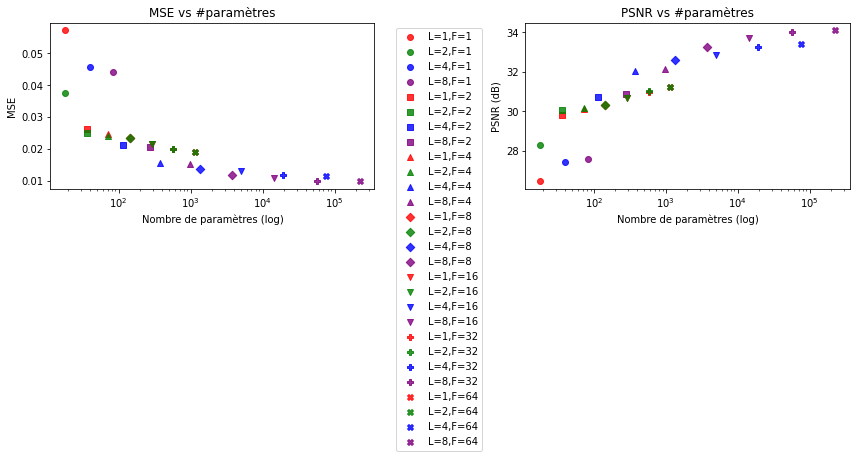

In [ ]:
results = [
    # F=1
    (1, 1, 18,    0.057212, 26.44),
    (2, 1, 18,    0.037576, 28.26),
    (4, 1, 40,    0.045749, 27.41),
    (8, 1, 84,    0.044189, 27.56),

    # F=2
    (1, 2, 36,    0.026296, 29.81),
    (2, 2, 36,    0.024954, 30.04),
    (4, 2, 116,   0.021297, 30.73),
    (8, 2, 276,   0.020615, 30.87),

    # F=4
    (1, 4, 72,    0.024545, 30.11),
    (2, 4, 72,    0.024179, 30.17),   
    (4, 4, 376,   0.015697, 32.05),   
    (8, 4, 984,   0.015413, 32.13),  

    # F=8
    (1, 8, 144,   0.023488, 30.30),  
    (2, 8, 144,   0.023381, 30.32),   
    (4, 8, 1328,  0.013859, 32.59),
    (8, 8, 3696,  0.011925, 33.25),

    # F=16
    (1, 16, 288,  0.021517, 30.68),
    (2, 16, 288,  0.021580, 30.67),
    (4, 16, 4960, 0.013157, 32.82),
    (8, 16, 14304,0.010760, 33.69),

    # F=32
    (1, 32, 576,   0.020103, 30.97),
    (2, 32, 576,   0.019998, 31.00),
    (4, 32, 19136, 0.011932, 33.24),
    (8, 32, 56256, 0.009947, 34.03),

    # F=64
    (1, 64, 1152,   0.018914, 31.24),
    (2, 64, 1152,   0.019056, 31.21),
    (4, 64, 75136,  0.011495, 33.40),
    (8, 64, 223104, 0.009813, 34.09),
]

params = [r[2] for r in results]
mse = [r[3] for r in results]
psnr = [r[4] for r in results]
labels = [f"L={r[0]},F={r[1]}" for r in results]

colors = {1:"red", 2:"green", 4:"blue", 8:"purple"}
markers = {1:"o", 2:"s", 4:"^", 8:"D", 16:"v", 32:"P", 64:"X"}

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for L,F,P,MSE,PSNR in results:
    plt.scatter(P, MSE, color=colors[L], marker=markers[F], alpha=0.8, label=f"L={L},F={F}")
plt.xscale("log")
plt.xlabel("Nombre de paramètres (log)")
plt.ylabel("MSE")
plt.title("MSE vs #paramètres")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1,2,2)
for L,F,P,MSE,PSNR in results:
    plt.scatter(P, PSNR, color=colors[L], marker=markers[F], alpha=0.8)
plt.xscale("log")
plt.xlabel("Nombre de paramètres (log)")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs #paramètres")

plt.tight_layout()
plt.show()

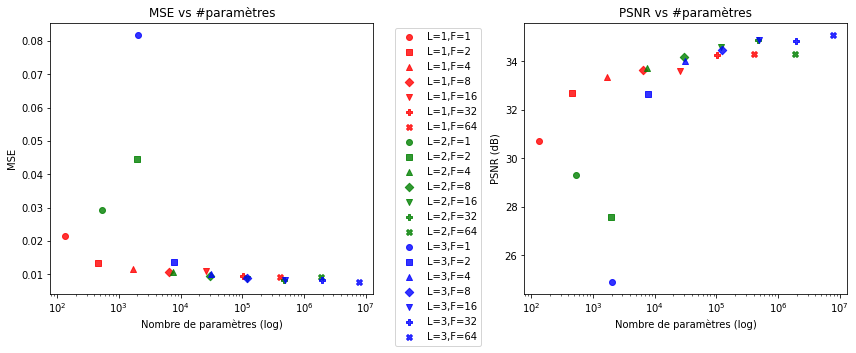

In [ ]:
# Résultats U-Net : (L, F0, Params, MSE, PSNR)
results = [
    (1, 1, 134, 0.021416, 30.70),
    (1, 2, 463, 0.013530, 32.70),
    (1, 4, 1709, 0.011671, 33.34),
    (1, 8, 6553, 0.010842, 33.66),
    (1, 16, 25649, 0.011005, 33.60),
    (1, 32, 101473, 0.009471, 34.25),
    (1, 64, 403649, 0.009338, 34.31),
    (2, 1, 528, 0.029369, 29.33),
    (2, 2, 1963, 0.044443, 27.57),
    (2, 4, 7557, 0.010704, 33.72),
    (2, 8, 29641, 0.009628, 34.18),
    (2, 16, 117393, 0.008736, 34.60),
    (2, 32, 467233, 0.008231, 34.86),
    (2, 64, 1864257, 0.009318, 34.32),
    (3, 1, 2028, 0.081680, 24.92),
    (3, 2, 7811, 0.013652, 32.66),
    (3, 4, 30645, 0.010020, 34.00),
    (3, 8, 121385, 0.008969, 34.48),
    (3, 16, 483153, 0.008214, 34.87),
    (3, 32, 1927841, 0.008247, 34.85),
    (3, 64, 7701825, 0.007830, 35.08),
]

colors = {1: "red", 2: "green", 3: "blue"}
markers = {1:"o", 2:"s", 4:"^", 8:"D", 16:"v", 32:"P", 64:"X"}

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for L,F,P,MSE,PSNR in results:
    plt.scatter(P, MSE, color=colors[L], marker=markers[F], alpha=0.8, label=f"L={L},F={F}")
plt.xscale("log")
plt.xlabel("Nombre de paramètres (log)")
plt.ylabel("MSE")
plt.title("MSE vs #paramètres")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1,2,2)
for L,F,P,MSE,PSNR in results:
    plt.scatter(P, PSNR, color=colors[L], marker=markers[F], alpha=0.8)
plt.xscale("log")
plt.xlabel("Nombre de paramètres (log)")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs #paramètres")

plt.tight_layout()
plt.show()

100%|██████████| 170M/170M [00:39<00:00, 4.35MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


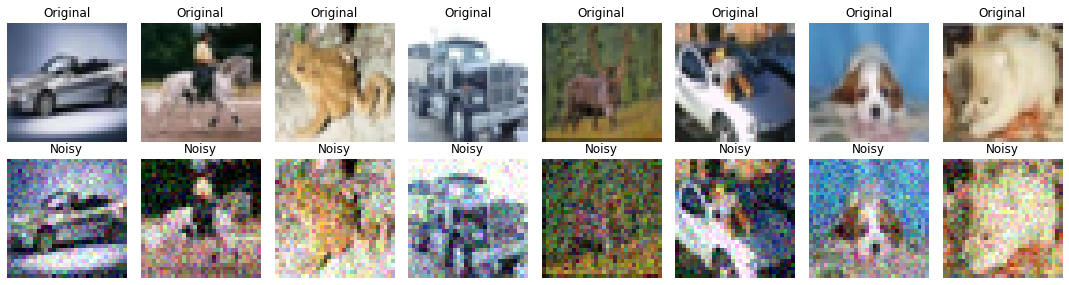

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# === 1. Prétraitements de base ===
transform = transforms.Compose([
    transforms.ToTensor(),  # convertit en [0,1]
])

# === 2. Chargement du dataset CIFAR-10 ===
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# === 3. Fonction pour bruiter les images ===
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

# === 4. Visualisation ===
dataiter = iter(trainloader)
images, labels = next(dataiter)

noisy_images = add_gaussian_noise(images)

# afficher quelques exemples
fig, axes = plt.subplots(2, 8, figsize=(15,4))
for i in range(8):
    # Image originale
    axes[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Image bruitée
    axes[1, i].imshow(np.transpose(noisy_images[i].numpy(), (1, 2, 0)))
    axes[1, i].set_title("Noisy")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ============================
# 1. Chargement du dataset CIFAR-10
# ============================
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# ============================
# 2. Ajout du bruit gaussien
# ============================
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

# ============================
# 3. Définition du U-Net
# ============================
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down

class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        # Ajustement si nécessaire (cropping ou padding)
        if x.shape != skip.shape:
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                          diffY // 2, diffY - diffY // 2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_layers=3, features_start=32):
        super().__init__()
        self.contracting_blocks = nn.ModuleList()
        self.expansive_blocks = nn.ModuleList()

        # Contracting path
        features = features_start
        for i in range(num_layers):
            self.contracting_blocks.append(ContractingBlock(in_channels, features))
            in_channels = features
            features *= 2

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Expansive path
        for i in range(num_layers):
            self.expansive_blocks.append(ExpansiveBlock(features, features // 2))
            features //= 2

        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        for block in self.contracting_blocks:
            x_conv, x = block(x)
            skips.append(x_conv)
        x = self.bottleneck(x)
        for block in self.expansive_blocks:
            skip = skips.pop()
            x = block(x, skip)
        return self.final_conv(x)

# ============================
# 4. Entraînement
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)

summary(unet, input_size=(3, 32, 32))

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3)

num_epochs = 5
for epoch in range(num_epochs):
    unet.train()
    running_loss = 0.0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        noisy_imgs = add_gaussian_noise(imgs).to(device)

        outputs = unet(noisy_imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.6f}")

# ============================
# 5. Visualisation sur des images test
# ============================
unet.eval()
dataiter = iter(testloader)
imgs, _ = next(dataiter)
imgs = imgs.to(device)
noisy_imgs = add_gaussian_noise(imgs).to(device)

with torch.no_grad():
    denoised = unet(noisy_imgs)

# Affichage
num_show = 6
fig, axes = plt.subplots(3, num_show, figsize=(15,6))
for i in range(num_show):
    axes[0,i].imshow(np.transpose(noisy_imgs[i].cpu().numpy(), (1,2,0)))
    axes[0,i].set_title("Noisy")
    axes[0,i].axis("off")

    axes[1,i].imshow(np.transpose(denoised[i].cpu().numpy(), (1,2,0)))
    axes[1,i].set_title("Denoised")
    axes[1,i].axis("off")

    axes[2,i].imshow(np.transpose(imgs[i].cpu().numpy(), (1,2,0)))
    axes[2,i].set_title("Clean")
    axes[2,i].axis("off")

plt.tight_layout()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
  ContractingBlock-8  [[-1, 32, 32, 32], [-1, 32, 16, 16]]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2

KeyboardInterrupt: 

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = unet.to(device)

summary(unet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
  ContractingBlock-8  [[-1, 32, 32, 32], [-1, 32, 16, 16]]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14        